# A Full Report of Analyzing News

## Introduction

From the data collected by crawling news with Scrapy (look at the `data-collection` directory, section 00 for more information), we try to perform simple analysis and transformation. These will include:

- Analysis of basic statistics about data.
- Hiding news category/sub-category, and predict news based on the texts only.
- Detect Named-Entity in every news, and try to figure some interesting fact on a day with those entities.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

## Analysis of Basic Statistics

Before analyzing data, simple import must be made.

In [2]:
df = pd.read_csv('../../data-collection/00-scrapy/vnexpress/news/news.csv')
df.head()

,Title,Description,Crawled Time,Category,Sub-category,Source,Content
0,Tổng bí thư: Người yếu thế cần nhận được trợ g...,Tổng bí thư đề nghị Hội Chữ thập đỏ thực hiện ...,30:12.7,Thoi Su,Chinh Tri,vnexpress.net,"Ngày 29/8, tại Trụ sở Trung ương Đảng, Tổng bí..."
1,Công nhân khó tìm việc,"Sau thời gian ""ngồi yên việc cũng đến"", hiện n...",30:14.9,Thoi Su,Lao Dong Viec Lam,vnexpress.net,"Một tháng qua, anh Thái Văn Đương, 28 tuổi, nộ..."
2,Bình Dương kỷ luật nhiều cá nhân liên quan 188...,Tỉnh ủy Bình Dương vừa kỷ luật một số tổ chức ...,30:13.9,Thoi Su,Chinh Tri,vnexpress.net,"Năm 2003, UBND tỉnh Bình Dương xin phê duyệt đ..."
3,Bộ trưởng Trần Hồng Hà: Sẽ đánh thuế cao người...,Người dân sử dụng đất trong hạn mức cho phép s...,30:13.9,Thoi Su,Chinh Tri,vnexpress.net,"Trong hai tiếng chiều 19/8, Bộ trưởng Tài nguy..."
4,TP HCM đề xuất tăng hai công chức mỗi phường,Thành phố kiến nghị cho tăng hai biên chế với ...,30:13.9,Thoi Su,Chinh Tri,vnexpress.net,Đề xuất được chính quyền thành phố nêu trong c...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1035 entries, 0 to 1034
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Title         1019 non-null   object
 1   Description   1028 non-null   object
 2   Crawled Time  1035 non-null   object
 3   Category      1035 non-null   object
 4   Sub-category  1035 non-null   object
 5   Source        1035 non-null   object
 6   Content       1016 non-null   object
dtypes: object(7)
memory usage: 56.7+ KB


In [4]:
# Remove column with null contents and titles
df.dropna(subset=['Content', 'Title'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 1034
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Title         1000 non-null   object
 1   Description   993 non-null    object
 2   Crawled Time  1000 non-null   object
 3   Category      1000 non-null   object
 4   Sub-category  1000 non-null   object
 5   Source        1000 non-null   object
 6   Content       1000 non-null   object
dtypes: object(7)
memory usage: 62.5+ KB


In [5]:
# What category is included
category = df['Category']
sub_category = df['Sub-category']

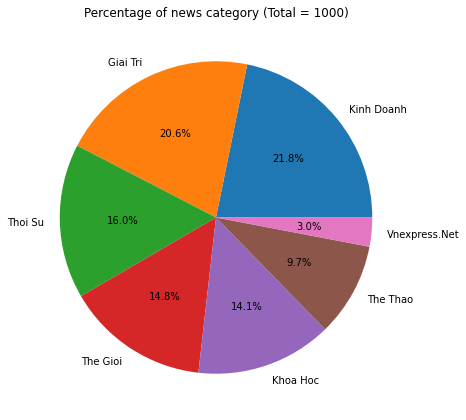

In [6]:
category.value_counts().plot.pie(title=f'Percentage of news category (Total = {len(df)})', autopct='%1.1f%%', figsize=(7,10), label='')
plt.show()

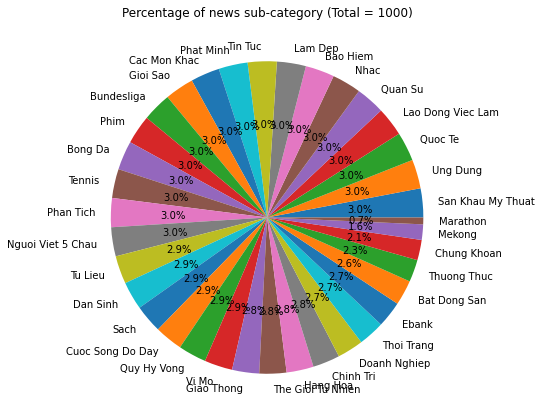

In [7]:
sub_category.value_counts().plot.pie(title=f'Percentage of news sub-category (Total = {len(df)})', autopct='%1.1f%%', figsize=(7,10), label='')
plt.show()

The pie chart shows a suspect category: vnexpress.net, which should be the name of the source. We try to print out those columns with that category.

In [8]:
df[df['Category'] == 'Vnexpress.Net']

,Title,Description,Crawled Time,Category,Sub-category,Source,Content
806,Conte: 'Đừng quên Son ghi 23 bàn mùa trước',\n,31:22.5,Vnexpress.Net,Bong Da,vnexpress.net,"""Son là cầu thủ rất quan trọng với tôi và Tott..."
807,Haaland ghi hattrick giúp Man City thắng ngược,\n,31:22.5,Vnexpress.Net,Bong Da,vnexpress.net,Hai hiệp đấu tại Etihad chứng kiến hai hình ản...
808,Milan thắng dễ nhờ ngôi sao trị giá 120 triệu USD,\n,31:22.5,Vnexpress.Net,Bong Da,vnexpress.net,Cầu thủ người Bồ Đào Nha mở tỉ số ở phút 21 vớ...
810,Dybala giúp Roma hòa Juventus,\n,31:22.5,Vnexpress.Net,Bong Da,vnexpress.net,"Ba tháng trước, rời sân Allianz trong nước m..."
811,Arsenal toàn thắng bốn trận đầu Ngoại hạng Anh,\n,31:22.5,Vnexpress.Net,Bong Da,vnexpress.net,Lần thứ ba thắng cả bốn trận mở màn Ngoại hạ...
812,Ten Hag ám chỉ Ronaldo có thể rời Man Utd,\n,31:22.5,Vnexpress.Net,Bong Da,vnexpress.net,"""Tôi không thể nói điều đó"", trả lời sau trậ..."
830,Fernandes bị chê dù giúp Man Utd thắng,\n,31:22.4,Vnexpress.Net,Bong Da,vnexpress.net,Scholes nói chơi không tốt như mọi người đán...
832,Guardiola: 'Tôi không cổ xuý thắng ngược',\n,31:22.4,Vnexpress.Net,Bong Da,vnexpress.net,"""Tôi thích một chiến thắng 4-0 hơn là thắng ng..."
833,Klopp: 'Liverpool không cố hạ nhục Bournemouth',\n,31:22.4,Vnexpress.Net,Bong Da,vnexpress.net,"Năm ngày khi thua đại kình địch Man Utd , Liv..."
834,Tuchel: 'Sterling toả sáng đúng lúc Chelsea cầ...,\n,31:22.4,Vnexpress.Net,Bong Da,vnexpress.net,"mất người từ phút 28, khi tiền vệ 21 tuổi Con..."


As can be seen from the table, these are all Sport News (The Thao), and their description are being incorrect as well. We try to fix the problem with these rows only.

In [9]:
incorrect_sport_df = df[df['Category'] == 'Vnexpress.Net']
df.drop(df[df['Category'] == 'Vnexpress.Net'].index, inplace=True)

incorrect_sport_df['Description'] = incorrect_sport_df['Description'].str.replace('\n', '')
incorrect_sport_df['Category'] = 'The Thao'
incorrect_sport_df

C:\Users\Administrator\AppData\Local\Temp\ipykernel_4784\1621317940.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  incorrect_sport_df['Description'] = incorrect_sport_df['Description'].str.replace('\n', '')
C:\Users\Administrator\AppData\Local\Temp\ipykernel_4784\1621317940.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  incorrect_sport_df['Category'] = 'The Thao'


,Title,Description,Crawled Time,Category,Sub-category,Source,Content
806,Conte: 'Đừng quên Son ghi 23 bàn mùa trước',,31:22.5,The Thao,Bong Da,vnexpress.net,"""Son là cầu thủ rất quan trọng với tôi và Tott..."
807,Haaland ghi hattrick giúp Man City thắng ngược,,31:22.5,The Thao,Bong Da,vnexpress.net,Hai hiệp đấu tại Etihad chứng kiến hai hình ản...
808,Milan thắng dễ nhờ ngôi sao trị giá 120 triệu USD,,31:22.5,The Thao,Bong Da,vnexpress.net,Cầu thủ người Bồ Đào Nha mở tỉ số ở phút 21 vớ...
810,Dybala giúp Roma hòa Juventus,,31:22.5,The Thao,Bong Da,vnexpress.net,"Ba tháng trước, rời sân Allianz trong nước m..."
811,Arsenal toàn thắng bốn trận đầu Ngoại hạng Anh,,31:22.5,The Thao,Bong Da,vnexpress.net,Lần thứ ba thắng cả bốn trận mở màn Ngoại hạ...
812,Ten Hag ám chỉ Ronaldo có thể rời Man Utd,,31:22.5,The Thao,Bong Da,vnexpress.net,"""Tôi không thể nói điều đó"", trả lời sau trậ..."
830,Fernandes bị chê dù giúp Man Utd thắng,,31:22.4,The Thao,Bong Da,vnexpress.net,Scholes nói chơi không tốt như mọi người đán...
832,Guardiola: 'Tôi không cổ xuý thắng ngược',,31:22.4,The Thao,Bong Da,vnexpress.net,"""Tôi thích một chiến thắng 4-0 hơn là thắng ng..."
833,Klopp: 'Liverpool không cố hạ nhục Bournemouth',,31:22.4,The Thao,Bong Da,vnexpress.net,"Năm ngày khi thua đại kình địch Man Utd , Liv..."
834,Tuchel: 'Sterling toả sáng đúng lúc Chelsea cầ...,,31:22.4,The Thao,Bong Da,vnexpress.net,"mất người từ phút 28, khi tiền vệ 21 tuổi Con..."


In [10]:
df = pd.concat([df, incorrect_sport_df], ignore_index=True)
df.shape

(1000, 7)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Title         1000 non-null   object
 1   Description   993 non-null    object
 2   Crawled Time  1000 non-null   object
 3   Category      1000 non-null   object
 4   Sub-category  1000 non-null   object
 5   Source        1000 non-null   object
 6   Content       1000 non-null   object
dtypes: object(7)
memory usage: 54.8+ KB


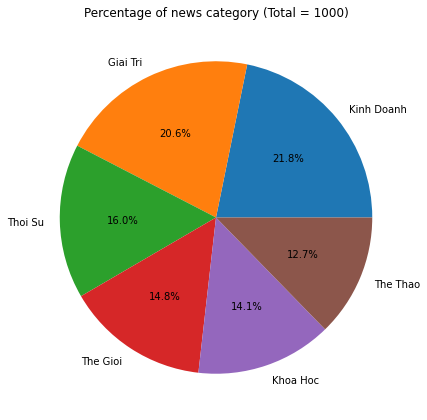

In [12]:
# Re-print the category distribution
category = df['Category']
category.value_counts().plot.pie(title=f'Percentage of news category (Total = {len(df)})', autopct='%1.1f%%', figsize=(7,10), label='')
plt.show()

**Examining the title/description/content length of every category**

In [13]:
df['Title length'] = df['Title'].str.len()
df['Title word count'] = df['Title'].apply(lambda x: len(str(x).split()))

df['Description length'] = df['Description'].str.len()
df['Description word count'] = df['Description'].apply(lambda x: len(str(x).split()))

df['Content length'] = df['Content'].str.len()
df['Content word count'] = df['Content'].apply(lambda x: len(str(x).split()))

df.head()

,Title,Description,Crawled Time,Category,Sub-category,Source,Content,Title length,Title word count,Description length,Description word count,Content length,Content word count
0,Tổng bí thư: Người yếu thế cần nhận được trợ g...,Tổng bí thư đề nghị Hội Chữ thập đỏ thực hiện ...,30:12.7,Thoi Su,Chinh Tri,vnexpress.net,"Ngày 29/8, tại Trụ sở Trung ương Đảng, Tổng bí...",69,16,148.0,34,1946,429
1,Công nhân khó tìm việc,"Sau thời gian ""ngồi yên việc cũng đến"", hiện n...",30:14.9,Thoi Su,Lao Dong Viec Lam,vnexpress.net,"Một tháng qua, anh Thái Văn Đương, 28 tuổi, nộ...",23,5,140.0,28,5654,1239
2,Bình Dương kỷ luật nhiều cá nhân liên quan 188...,Tỉnh ủy Bình Dương vừa kỷ luật một số tổ chức ...,30:13.9,Thoi Su,Chinh Tri,vnexpress.net,"Năm 2003, UBND tỉnh Bình Dương xin phê duyệt đ...",61,13,125.0,29,945,205
3,Bộ trưởng Trần Hồng Hà: Sẽ đánh thuế cao người...,Người dân sử dụng đất trong hạn mức cho phép s...,30:13.9,Thoi Su,Chinh Tri,vnexpress.net,"Trong hai tiếng chiều 19/8, Bộ trưởng Tài nguy...",72,16,151.0,33,24101,5393
4,TP HCM đề xuất tăng hai công chức mỗi phường,Thành phố kiến nghị cho tăng hai biên chế với ...,30:13.9,Thoi Su,Chinh Tri,vnexpress.net,Đề xuất được chính quyền thành phố nêu trong c...,45,10,159.0,35,1355,292


C:\Users\Administrator\AppData\Local\Temp\ipykernel_4784\2219271521.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_grouped = df.groupby('Category')['Category', 'Title length', 'Title word count', 'Description length', 'Description word count', 'Content length', 'Content word count'].mean()


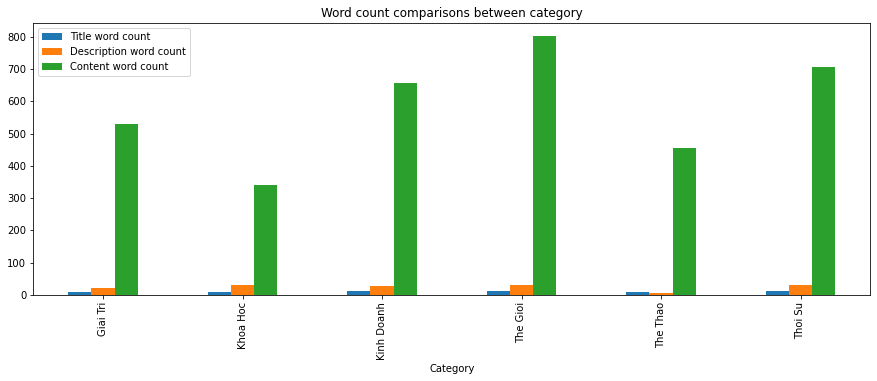

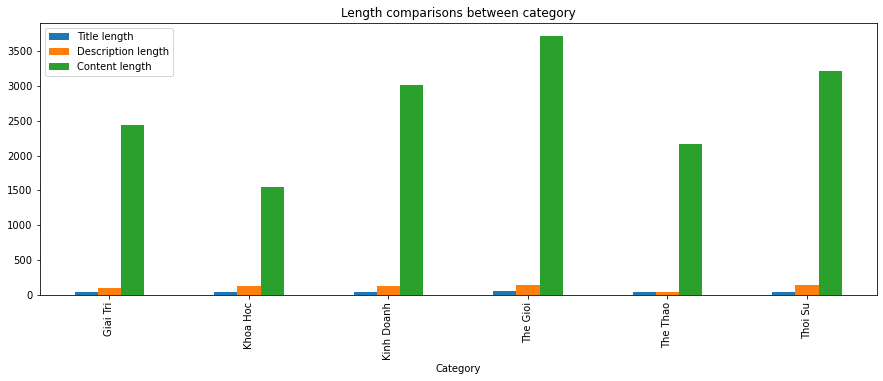

In [14]:
df_grouped = df.groupby('Category')['Category', 'Title length', 'Title word count', 'Description length', 'Description word count', 'Content length', 'Content word count'].mean()
df_grouped[['Title word count', 'Description word count', 'Content word count']].plot.bar(figsize=(15, 5), title='Word count comparisons between category')
df_grouped[['Title length', 'Description length', 'Content length']].plot.bar(figsize=(15, 5), title='Length comparisons between category')
plt.show()

In [15]:
df_grouped.describe()

,Title length,Title word count,Description length,Description word count,Content length,Content word count
count,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000
mean,46.019954,10.142257,112.010469,24.242577,2683.144185,581.636319
std,4.003706,1.047048,40.884133,9.408450,781.461496,171.177618
min,41.320388,8.606299,36.741667,6.929134,1554.014184,340.219858
25%,42.499553,9.438021,102.037354,21.910951,2236.342873,474.482083
50%,46.699623,10.394479,130.775132,28.434999,2723.360871,592.308943
75%,48.731408,11.032621,136.404938,29.717546,3162.446273,693.735221
max,50.891892,11.093750,143.031250,31.775000,3715.317568,802.229730


## News Category & Sub-Category Prediction

We are trying to figure out the news category by title (short document) + content (long document) using TF-IDF and SVM. First, we will do tile and content separately, then combine to observe the performance.

In [16]:
df_title_category = df[['Title', 'Category']]
df_content_category = df[['Content', 'Category']]
df_title_subcategory = df[['Title', 'Sub-category']]
df_content_subcategory = df[['Content', 'Sub-category']]

In [17]:
def classify(dataframe, result_dict = {}):
    X = dataframe.iloc[:, 0].values
    y = dataframe.iloc[:, 1].values

    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('svm', SVC())
    ])
    grid_params = {
        'tfidf__max_df': np.linspace(0.2, 1, 5),
        'tfidf__binary': [True, False],
        'svm__kernel': ['linear', 'poly', 'rbf', 'sigmoid']
    }
    
    clf = GridSearchCV(pipeline, grid_params)
    clf.fit(X, y)
    
    display(pd.DataFrame(clf.cv_results_).sort_values('rank_test_score'))
    
    result_dict[tuple(dataframe.columns.tolist())] = clf.best_score_
    
    def inference(classifier, documents):
        y_pred = classifier.predict(documents)
        return y_pred
    
    return lambda x: inference(clf.best_estimator_, x)

In [18]:
title_category_model_instance = classify(df_title_category)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svm__kernel,param_tfidf__binary,param_tfidf__max_df,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,0.123557,0.003247,0.017920,0.000397,linear,False,0.2,"{'svm__kernel': 'linear', 'tfidf__binary': Fal...",0.665,0.700,0.675,0.695,0.700,0.687,0.014353,1
6,0.135959,0.011000,0.019367,0.001842,linear,False,0.4,"{'svm__kernel': 'linear', 'tfidf__binary': Fal...",0.665,0.700,0.675,0.695,0.700,0.687,0.014353,1
7,0.133231,0.005018,0.020425,0.001806,linear,False,0.6,"{'svm__kernel': 'linear', 'tfidf__binary': Fal...",0.665,0.700,0.675,0.695,0.700,0.687,0.014353,1
8,0.134617,0.006510,0.020660,0.002117,linear,False,0.8,"{'svm__kernel': 'linear', 'tfidf__binary': Fal...",0.665,0.700,0.675,0.695,0.700,0.687,0.014353,1
9,0.130353,0.007473,0.019683,0.001212,linear,False,1.0,"{'svm__kernel': 'linear', 'tfidf__binary': Fal...",0.665,0.700,0.675,0.695,0.700,0.687,0.014353,1
0,0.128328,0.014032,0.017847,0.001184,linear,True,0.2,"{'svm__kernel': 'linear', 'tfidf__binary': Tru...",0.660,0.695,0.680,0.695,0.695,0.685,0.013784,6
1,0.125139,0.003175,0.017923,0.001183,linear,True,0.4,"{'svm__kernel': 'linear', 'tfidf__binary': Tru...",0.660,0.695,0.680,0.695,0.695,0.685,0.013784,6
2,0.122569,0.001935,0.018151,0.000581,linear,True,0.6,"{'svm__kernel': 'linear', 'tfidf__binary': Tru...",0.660,0.695,0.680,0.695,0.695,0.685,0.013784,6
3,0.121393,0.002433,0.017764,0.000593,linear,True,0.8,"{'svm__kernel': 'linear', 'tfidf__binary': Tru...",0.660,0.695,0.680,0.695,0.695,0.685,0.013784,6
4,0.121784,0.002162,0.017703,0.000817,linear,True,1.0,"{'svm__kernel': 'linear', 'tfidf__binary': Tru...",0.660,0.695,0.680,0.695,0.695,0.685,0.013784,6


In [19]:
content_category_model_instance = classify(df_content_category)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svm__kernel,param_tfidf__binary,param_tfidf__max_df,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,2.639464,0.167789,0.433322,0.020852,linear,True,0.8,"{'svm__kernel': 'linear', 'tfidf__binary': Tru...",0.910,0.905,0.940,0.865,0.930,0.910,0.025884,1
4,2.633135,0.063178,0.430813,0.027846,linear,True,1.0,"{'svm__kernel': 'linear', 'tfidf__binary': Tru...",0.910,0.905,0.940,0.865,0.930,0.910,0.025884,1
2,2.430019,0.139328,0.407824,0.019788,linear,True,0.6,"{'svm__kernel': 'linear', 'tfidf__binary': Tru...",0.915,0.910,0.940,0.855,0.925,0.909,0.028879,3
31,1.709217,0.061787,0.338403,0.054425,sigmoid,True,0.4,"{'svm__kernel': 'sigmoid', 'tfidf__binary': Tr...",0.900,0.915,0.940,0.855,0.920,0.906,0.028531,4
7,2.071609,0.158909,0.388834,0.053604,linear,False,0.6,"{'svm__kernel': 'linear', 'tfidf__binary': Fal...",0.920,0.900,0.920,0.875,0.910,0.905,0.016733,5
34,2.055550,0.068656,0.402530,0.017768,sigmoid,True,1.0,"{'svm__kernel': 'sigmoid', 'tfidf__binary': Tr...",0.890,0.905,0.940,0.865,0.925,0.905,0.026268,6
39,1.599063,0.026840,0.345992,0.010516,sigmoid,False,1.0,"{'svm__kernel': 'sigmoid', 'tfidf__binary': Fa...",0.920,0.910,0.920,0.865,0.905,0.904,0.020347,7
8,2.140588,0.113976,0.373766,0.028296,linear,False,0.8,"{'svm__kernel': 'linear', 'tfidf__binary': Fal...",0.920,0.905,0.915,0.870,0.910,0.904,0.017720,7
9,2.167666,0.107890,0.377654,0.013525,linear,False,1.0,"{'svm__kernel': 'linear', 'tfidf__binary': Fal...",0.915,0.915,0.915,0.865,0.910,0.904,0.019596,7
1,2.446557,0.214612,0.407403,0.032330,linear,True,0.4,"{'svm__kernel': 'linear', 'tfidf__binary': Tru...",0.905,0.910,0.935,0.850,0.920,0.904,0.028879,7


In [20]:
title_subcategory_model_instance = classify(df_title_subcategory)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svm__kernel,param_tfidf__binary,param_tfidf__max_df,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.159813,0.001181,0.022551,0.000789,linear,True,0.2,"{'svm__kernel': 'linear', 'tfidf__binary': Tru...",0.600,0.535,0.495,0.575,0.510,0.543,0.039319,1
1,0.158825,0.001890,0.023311,0.000999,linear,True,0.4,"{'svm__kernel': 'linear', 'tfidf__binary': Tru...",0.600,0.535,0.495,0.575,0.510,0.543,0.039319,1
2,0.158010,0.001145,0.023162,0.000847,linear,True,0.6,"{'svm__kernel': 'linear', 'tfidf__binary': Tru...",0.600,0.535,0.495,0.575,0.510,0.543,0.039319,1
3,0.157853,0.001865,0.022542,0.000864,linear,True,0.8,"{'svm__kernel': 'linear', 'tfidf__binary': Tru...",0.600,0.535,0.495,0.575,0.510,0.543,0.039319,1
4,0.159906,0.002004,0.023108,0.001432,linear,True,1.0,"{'svm__kernel': 'linear', 'tfidf__binary': Tru...",0.600,0.535,0.495,0.575,0.510,0.543,0.039319,1
8,0.159383,0.002166,0.023157,0.000921,linear,False,0.8,"{'svm__kernel': 'linear', 'tfidf__binary': Fal...",0.600,0.535,0.495,0.565,0.510,0.541,0.037868,6
7,0.157916,0.001326,0.022470,0.000480,linear,False,0.6,"{'svm__kernel': 'linear', 'tfidf__binary': Fal...",0.600,0.535,0.495,0.565,0.510,0.541,0.037868,6
9,0.157805,0.001020,0.022782,0.000439,linear,False,1.0,"{'svm__kernel': 'linear', 'tfidf__binary': Fal...",0.600,0.535,0.495,0.565,0.510,0.541,0.037868,6
5,0.159287,0.001624,0.022843,0.000707,linear,False,0.2,"{'svm__kernel': 'linear', 'tfidf__binary': Fal...",0.600,0.535,0.495,0.565,0.510,0.541,0.037868,6
6,0.159165,0.000770,0.022426,0.000330,linear,False,0.4,"{'svm__kernel': 'linear', 'tfidf__binary': Fal...",0.600,0.535,0.495,0.565,0.510,0.541,0.037868,6


In [21]:
content_subcategory_model_instance = classify(df_content_subcategory)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svm__kernel,param_tfidf__binary,param_tfidf__max_df,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
7,2.757905,0.210771,0.450458,0.078482,linear,False,0.6,"{'svm__kernel': 'linear', 'tfidf__binary': Fal...",0.780,0.700,0.680,0.695,0.740,0.719,0.036387,1
8,2.939777,0.101116,0.428222,0.005591,linear,False,0.8,"{'svm__kernel': 'linear', 'tfidf__binary': Fal...",0.775,0.695,0.675,0.690,0.750,0.717,0.038549,2
9,2.961964,0.011896,0.441837,0.005137,linear,False,1.0,"{'svm__kernel': 'linear', 'tfidf__binary': Fal...",0.770,0.690,0.675,0.695,0.740,0.714,0.035412,3
39,2.778878,0.016515,0.437269,0.005432,sigmoid,False,1.0,"{'svm__kernel': 'sigmoid', 'tfidf__binary': Fa...",0.765,0.700,0.675,0.695,0.725,0.712,0.030919,4
1,2.398190,0.051376,0.376206,0.035508,linear,True,0.4,"{'svm__kernel': 'linear', 'tfidf__binary': Tru...",0.720,0.705,0.690,0.725,0.715,0.711,0.012410,5
38,2.710899,0.063545,0.423927,0.006230,sigmoid,False,0.8,"{'svm__kernel': 'sigmoid', 'tfidf__binary': Fa...",0.760,0.705,0.670,0.680,0.735,0.710,0.033615,6
3,2.973076,0.053499,0.439817,0.009483,linear,True,0.8,"{'svm__kernel': 'linear', 'tfidf__binary': Tru...",0.720,0.700,0.685,0.730,0.710,0.709,0.015620,7
6,2.283209,0.010467,0.347250,0.003946,linear,False,0.4,"{'svm__kernel': 'linear', 'tfidf__binary': Fal...",0.760,0.685,0.680,0.685,0.725,0.707,0.031081,8
4,3.058928,0.019364,0.453948,0.002706,linear,True,1.0,"{'svm__kernel': 'linear', 'tfidf__binary': Tru...",0.720,0.685,0.685,0.735,0.710,0.707,0.019647,9
37,2.502336,0.020801,0.403602,0.017565,sigmoid,False,0.6,"{'svm__kernel': 'sigmoid', 'tfidf__binary': Fa...",0.760,0.700,0.675,0.685,0.710,0.706,0.029563,10


In [23]:
df_content_category.columns = df_content_category.columns.str.replace('Content', 'Title')
combined_category_model_instance = classify(pd.concat([df_content_category, df_title_category]))

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svm__kernel,param_tfidf__binary,param_tfidf__max_df,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
26,3.307578,0.721563,0.468069,0.245320,rbf,False,0.4,"{'svm__kernel': 'rbf', 'tfidf__binary': False,...",0.9450,0.9400,0.8700,0.8475,0.7850,0.8775,0.059958,1
7,1.881757,0.374651,0.373648,0.214758,linear,False,0.6,"{'svm__kernel': 'linear', 'tfidf__binary': Fal...",0.9450,0.9425,0.8775,0.8350,0.7875,0.8775,0.061135,2
8,1.876846,0.373521,0.375547,0.210491,linear,False,0.8,"{'svm__kernel': 'linear', 'tfidf__binary': Fal...",0.9450,0.9425,0.8775,0.8350,0.7875,0.8775,0.061135,2
9,1.883148,0.376915,0.373847,0.212208,linear,False,1.0,"{'svm__kernel': 'linear', 'tfidf__binary': Fal...",0.9450,0.9425,0.8775,0.8350,0.7875,0.8775,0.061135,2
25,2.884720,0.368864,0.465687,0.300424,rbf,False,0.2,"{'svm__kernel': 'rbf', 'tfidf__binary': False,...",0.9450,0.9350,0.8700,0.8225,0.8025,0.8750,0.057511,5
27,3.423432,0.928302,0.482292,0.238453,rbf,False,0.6,"{'svm__kernel': 'rbf', 'tfidf__binary': False,...",0.9450,0.9400,0.8700,0.8300,0.7675,0.8705,0.067276,6
38,1.672535,0.389826,0.344888,0.195500,sigmoid,False,0.8,"{'svm__kernel': 'sigmoid', 'tfidf__binary': Fa...",0.9450,0.9200,0.8700,0.8325,0.7850,0.8705,0.057888,6
28,3.449568,0.964444,0.486125,0.236218,rbf,False,0.8,"{'svm__kernel': 'rbf', 'tfidf__binary': False,...",0.9450,0.9400,0.8700,0.8300,0.7675,0.8705,0.067276,6
29,3.411758,0.926673,0.476835,0.231897,rbf,False,1.0,"{'svm__kernel': 'rbf', 'tfidf__binary': False,...",0.9450,0.9400,0.8700,0.8300,0.7675,0.8705,0.067276,6
37,1.671842,0.385404,0.343358,0.194407,sigmoid,False,0.6,"{'svm__kernel': 'sigmoid', 'tfidf__binary': Fa...",0.9450,0.9200,0.8700,0.8325,0.7850,0.8705,0.057888,6


In [24]:
# Testing the combined_category_model_instance
combined_category_model_instance(['Dời lồng tôm hùm, thu hoạch hoa màu tránh bão Noru'])

array(['Kinh Doanh'], dtype=object)